In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-02-28 19:20:02.606988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Resize the image to the desired input size for the model
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/leader/Downloads/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 4 classes.


2023-02-28 19:20:15.592720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'training']

In [5]:
len(dataset)

68

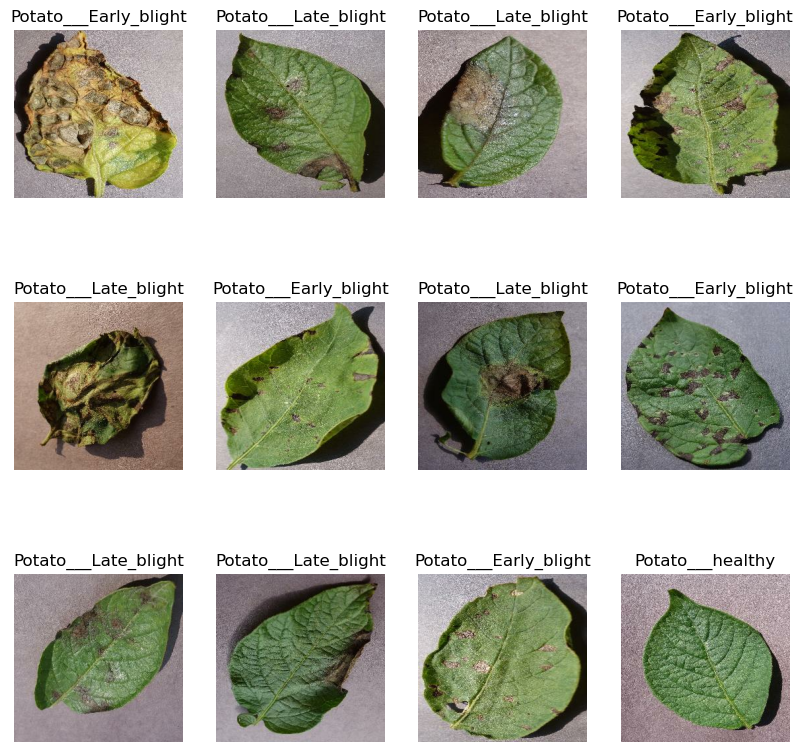

In [63]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# 80% ==> training
# 20% ==> 10% validation , 10% test

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds= dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size= len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes=3

model = models.Sequential([
    resize_and_rescale, 
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
	layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
	layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
	layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [24]:
model.compile(
	optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [91]:
history = model.fit(
    train_ds, 
    epochs = 30, 
    batch_size = BATCH_SIZE,
    verbose=1, 
    validation_data = val_ds
)

Epoch 1/30
54/54 [==============================] - 184s 3s/step - loss: 0.1711 - accuracy: 0.9334 - val_loss: 0.0716 - val_accuracy: 0.9688
Epoch 2/30
54/54 [==============================] - 216s 4s/step - loss: 0.0778 - accuracy: 0.9734 - val_loss: 0.3721 - val_accuracy: 0.8698
Epoch 3/30
54/54 [==============================] - 305s 6s/step - loss: 0.0868 - accuracy: 0.9647 - val_loss: 0.4758 - val_accuracy: 0.8594
Epoch 4/30
54/54 [==============================] - 225s 4s/step - loss: 0.0654 - accuracy: 0.9757 - val_loss: 0.1841 - val_accuracy: 0.9375
Epoch 5/30
54/54 [==============================] - 219s 4s/step - loss: 0.0727 - accuracy: 0.9728 - val_loss: 0.5409 - val_accuracy: 0.8594
Epoch 6/30
54/54 [==============================] - 652s 12s/step - loss: 0.1163 - accuracy: 0.9589 - val_loss: 0.4252 - val_accuracy: 0.8594
Epoch 7/30
54/54 [==============================] - 182s 3s/step - loss: 0.0608 - accuracy: 0.9809 - val_loss: 0.1854 - val_accuracy: 0.9427
Epoch 8/30
5

In [92]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 9s 1s/step - loss: 0.0053 - accuracy: 1.0000


[0.005306019447743893, 1.0]

In [93]:
history

In [94]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [95]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [96]:
history.history["accuracy"]

[0.9334490895271301,
 0.9733796119689941,
 0.9646990895271301,
 0.9756944179534912,
 0.9728009104728699,
 0.9589120149612427,
 0.9809027910232544,
 0.9826388955116272,
 0.9612268805503845,
 0.9803240895271301,
 0.9861111044883728,
 0.9878472089767456,
 0.9872685074806213,
 0.9901620149612427,
 0.9872685074806213,
 0.9895833134651184,
 0.9751157164573669,
 0.9913194179534912,
 0.9924768805503845,
 0.9820601940155029,
 0.9820601940155029,
 0.984375,
 0.9884259104728699,
 0.9768518805503845,
 0.9918981194496155,
 0.9959490895271301,
 0.9664351940155029,
 0.9959490895271301,
 0.9936342835426331,
 0.9953703880310059]

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

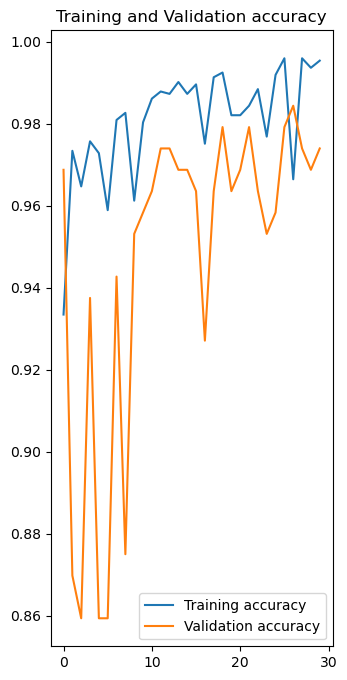

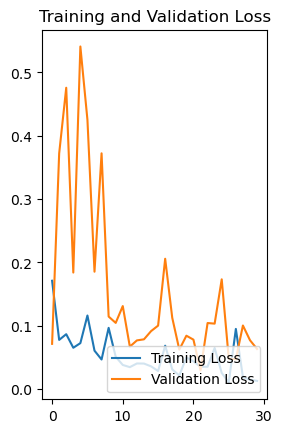

In [98]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label='Training accuracy')
plt.plot(range(30), val_acc, label = 'Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')
plt.show()

plt.subplot(1, 2, 1)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label = 'Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

In [99]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

first predicted image
first image's actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


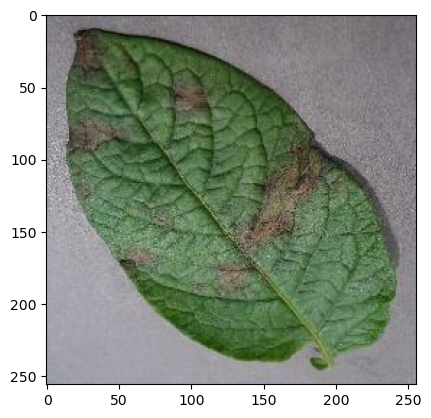

In [100]:
print("first predicted image")
plt.imshow(first_image)
print("first image's actual label:", class_names[first_label])

batch_prediction = model.predict(images_batch)
print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [102]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 55ms/step


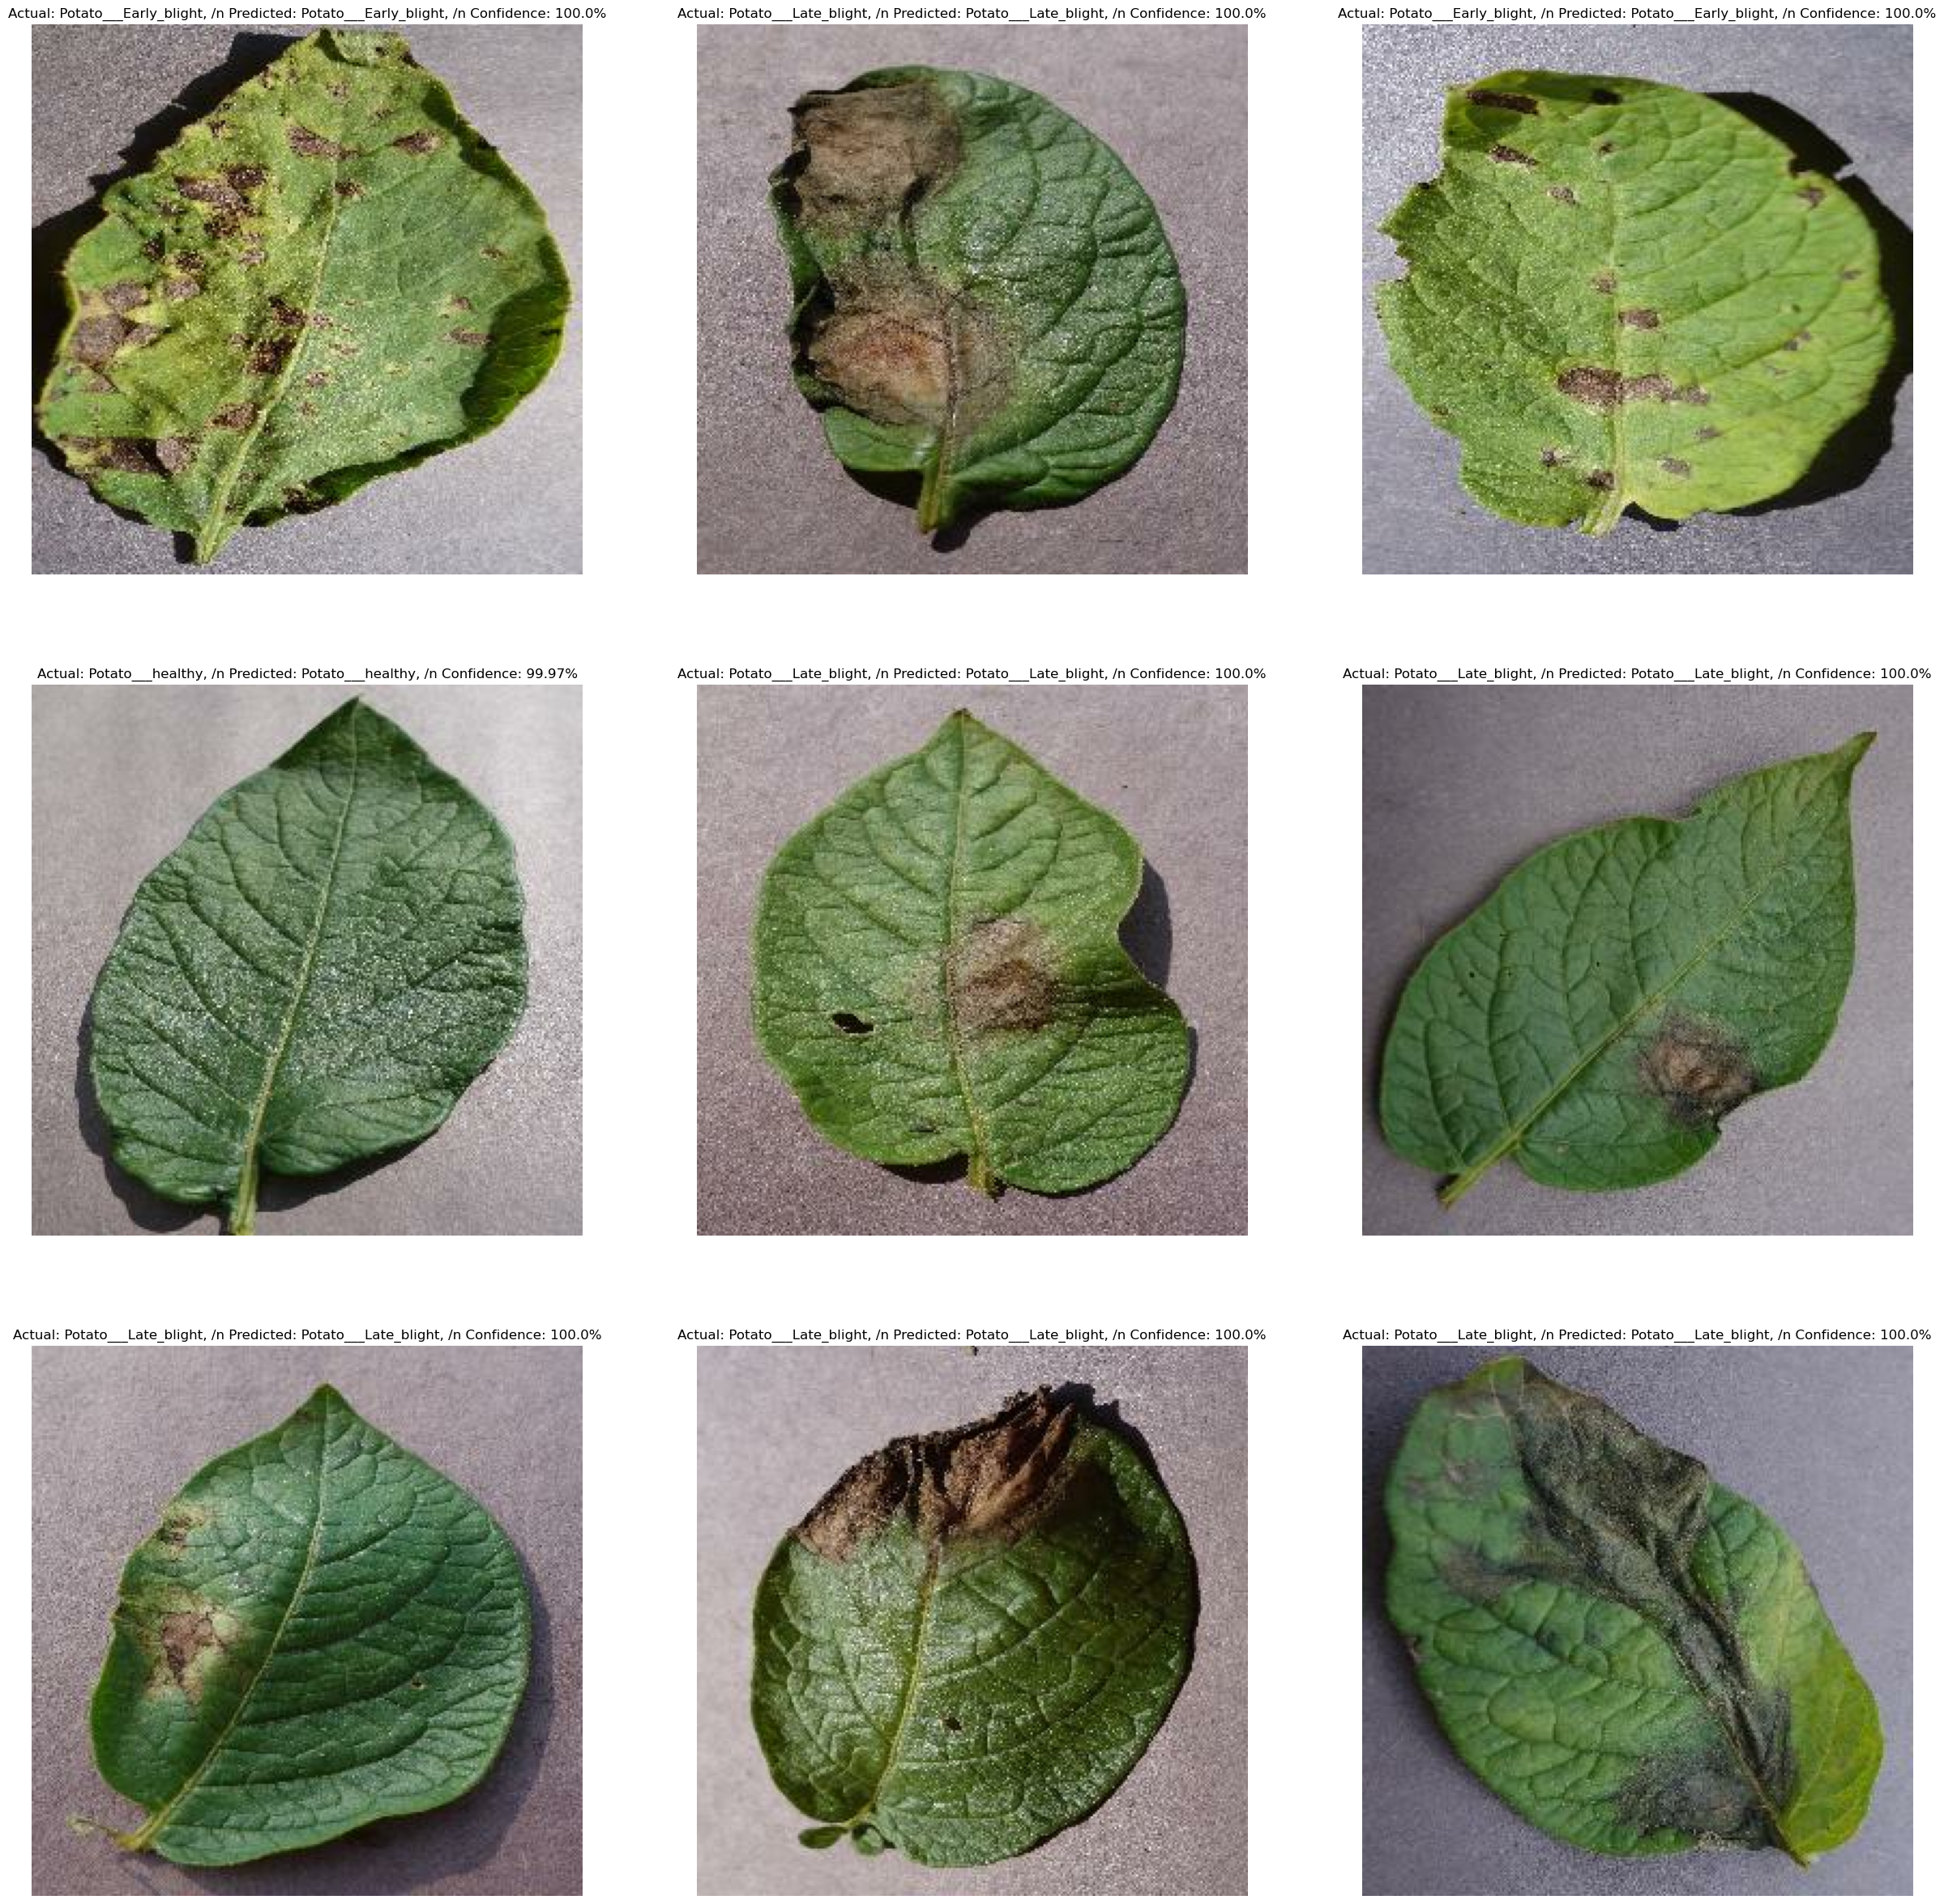

In [105]:
plt.figure(figsize=(30,30))
for images, lables in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[lables[i]]

        plt.title(f"Actual: {actual_class}, /n Predicted: {predicted_class}, /n Confidence: {confidence}%") 

        plt.axis("off")


In [128]:
import os
model_version=max([bool(j) for j in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2/assets


INFO:tensorflow:Assets written to: models/2/assets


In [108]:
model_version=1


INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets
